# Introduction

This project focuses on predicting whether a user will click on an online advertisement using machine learning models. By analyzing user behavior (like internet usage, time on site) and demographic information (such as age, income, location), we train two models—Random Forest and XGBoost—to forecast ad clicks.

Accurate CTR prediction helps marketers:
    Target the right audience,
    Increase conversion rates,
    Improve ad placement and reduce wasted spend.


# Importing Libraries

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns


# Loading the Dataset

In [3]:
df = pd.read_csv('ad_records.csv')
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


# Feature Extraction

In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Part_Of_Day'] = df['Hour'].apply(part_of_day)
df['Part_Of_Day'] = LabelEncoder().fit_transform(df['Part_Of_Day'])

df['AgeGroup'] = pd.cut(df['Age'], bins=[17, 25, 35, 50, 65], labels=[0, 1, 2, 3])
df['IncomeGroup'] = pd.qcut(df['Area Income'], q=4, labels=[0, 1, 2, 3])

df['Site_Internet_Interaction'] = df['Daily Time Spent on Site'] * df['Daily Internet Usage']
df['Age_Income_Interaction'] = df['Age'] * df['Area Income']
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,Hour,Day,Month,DayOfWeek,Is_Weekend,Part_Of_Day,AgeGroup,IncomeGroup,Site_Internet_Interaction,Age_Income_Interaction
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0,21,9,6,3,0,3,1,3,10760.3958,2223419.20
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0,17,16,1,5,1,1,1,2,8645.2041,1917048.06
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0,10,29,6,2,0,2,1,2,7673.6520,1736314.50
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0,14,21,6,1,0,0,1,1,12405.3396,1573066.04
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1,10,21,7,3,0,2,1,1,9919.7518,1629741.90


# Encoding Categorical Data Using Label Encoder

In [5]:
label_encoders = {}
for col in ['City', 'Gender', 'Country']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,Hour,Day,Month,DayOfWeek,Is_Weekend,Part_Of_Day,AgeGroup,IncomeGroup,Site_Internet_Interaction,Age_Income_Interaction
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,234,1,174,2016-06-09 21:43:05,0,21,9,6,3,0,3,1,3,10760.3958,2223419.20
1,41.73,31.0,61840.26,207.17,Optional full-range projection,460,1,166,2016-01-16 17:56:05,0,17,16,1,5,1,1,1,2,8645.2041,1917048.06
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,379,0,71,2016-06-29 10:50:45,0,10,29,6,2,0,2,1,2,7673.6520,1736314.50
3,59.88,28.0,56180.93,207.17,Balanced empowering success,269,0,205,2016-06-21 14:32:32,0,14,21,6,1,0,0,1,1,12405.3396,1573066.04
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,495,0,149,2016-07-21 10:54:35,1,10,21,7,3,0,2,1,1,9919.7518,1629741.90


# Feature Selection

In [6]:

x = df.drop(['Clicked on Ad', 'Ad Topic Line', 'Timestamp'], axis=1)
y = df['Clicked on Ad']

# Training and Testing the Dataset

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model Accuracy (Random Forest)

In [8]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(x_train, y_train)
y_pred_rf = clf_rf.predict(x_test)
print(f"RandomForest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

RandomForest Accuracy: 0.8425


# Classification Report (Random Forest)

In [9]:
print("\nRandomForest Classification Report:")
print(pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose())

print("RandomForest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


RandomForest Classification Report:
              precision    recall  f1-score    support
0              0.831909  0.863905  0.847605  1014.0000
1              0.854277  0.820487  0.837041   986.0000
accuracy       0.842500  0.842500  0.842500     0.8425
macro avg      0.843093  0.842196  0.842323  2000.0000
weighted avg   0.842936  0.842500  0.842397  2000.0000
RandomForest Confusion Matrix:
[[876 138]
 [177 809]]


# Feature Importance (Random Forest)

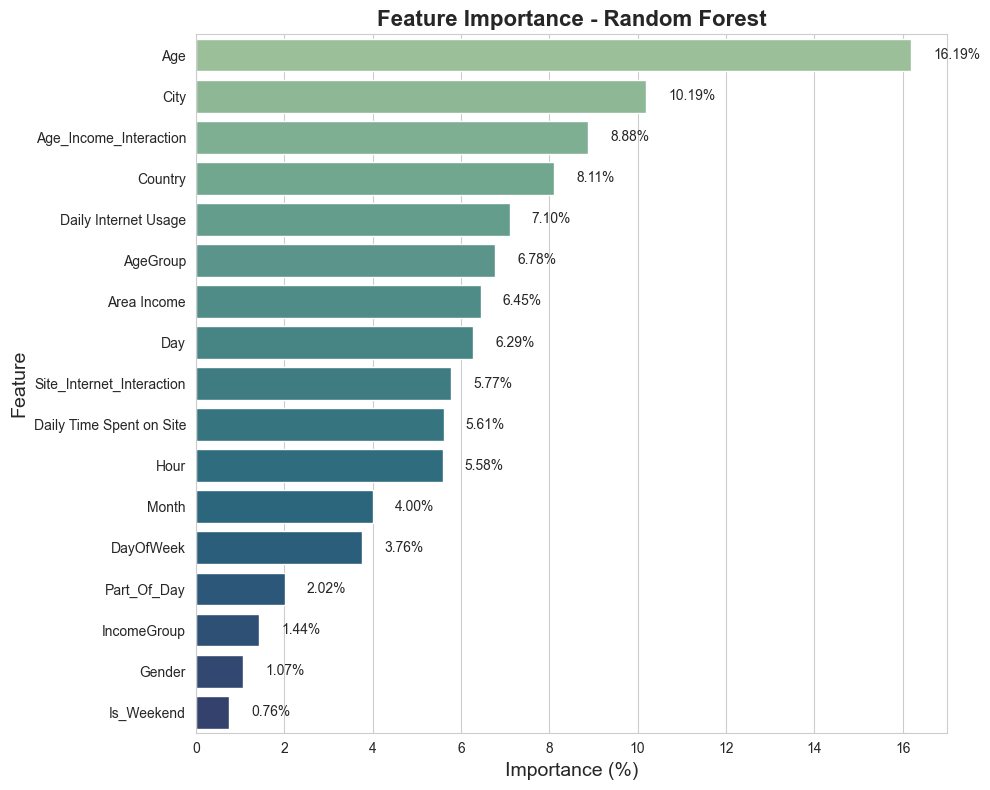

In [10]:
rf_importances = clf_rf.feature_importances_
rf_feature_names = x_train.columns
rf_importance_df = pd.DataFrame({
    'feature': rf_feature_names,
    'importance': (rf_importances / sum(rf_importances)) * 100
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
barplot = sns.barplot(
    x="importance", y="feature",
    data=rf_importance_df,
    hue="feature",
    palette="crest"
)
for i, v in enumerate(rf_importance_df['importance']):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center')
plt.xlabel("Importance (%)",fontsize=14)
plt.ylabel("Feature",fontsize=14)
plt.title("Feature Importance - Random Forest", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Using XGBoost


In [11]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

x_train['AgeGroup'] = x_train['AgeGroup'].astype(int)
x_train['IncomeGroup'] = x_train['IncomeGroup'].astype(int)
x_test['AgeGroup'] = x_test['AgeGroup'].astype(int)
x_test['IncomeGroup'] = x_test['IncomeGroup'].astype(int)

# Model Accuracy (XGBoost)

In [12]:
xgb_clf = xgb.XGBClassifier(random_state=42)
grid = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='f1', verbose=1)
grid.fit(x_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Accuracy: 0.8710


In [13]:

print(f"Best Hyperparameters: {grid.best_params_}")


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


# Classification Report (XGBoost)

In [14]:
print("\nClassification Report:")
print(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose())


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support
0              0.867704  0.879684  0.873653  1014.000
1              0.874486  0.862069  0.868233   986.000
accuracy       0.871000  0.871000  0.871000     0.871
macro avg      0.871095  0.870877  0.870943  2000.000
weighted avg   0.871047  0.871000  0.870981  2000.000

Confusion Matrix:
[[892 122]
 [136 850]]


# AUC-ROC Curve

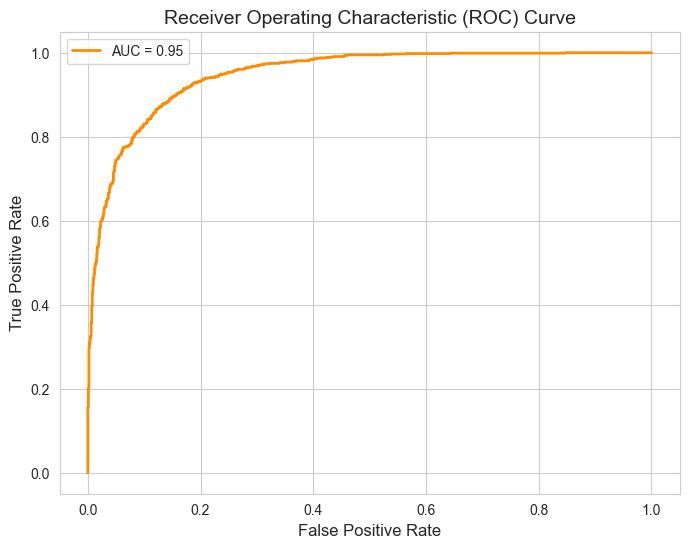

In [15]:
probs = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
auc_score = roc_auc_score(y_test, probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {auc_score:.2f}")

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Feature Importance (XGBoost)

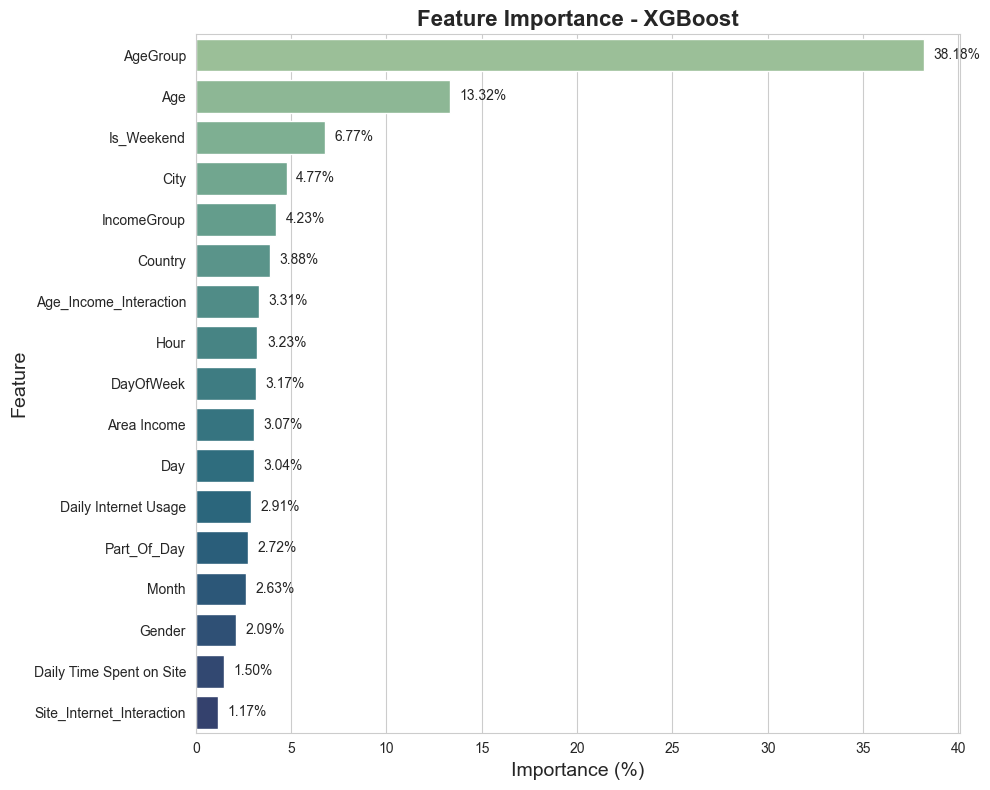

In [16]:
feature_importances = best_model.feature_importances_
feature_names = x_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': (feature_importances / sum(feature_importances)) * 100
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
barplot = sns.barplot(
    x="importance", y="feature",
    data=importance_df,
    hue="feature",
    palette="crest"
)
for i, v in enumerate(importance_df['importance']):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center')
plt.xlabel("Importance (%)",fontsize=14)
plt.ylabel("Feature",fontsize=14)
plt.title("Feature Importance - XGBoost", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


Total Clicks by Age Group:
AgeGroup
0     261
1    1217
2    2896
3     543
Name: Clicked on Ad, dtype: int64

Click-Through Rate (CTR) by Age Group:
AgeGroup
0    0.246459
1    0.295532
2    0.692823
3    0.844479
Name: Clicked on Ad, dtype: float64


/var/folders/xd/4cftcc7x5_50jz5lxl6887vh0000gn/T/ipykernel_8709/1692793869.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_clicks = df.groupby('AgeGroup')['Clicked on Ad'].sum()
/var/folders/xd/4cftcc7x5_50jz5lxl6887vh0000gn/T/ipykernel_8709/1692793869.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_impressions = df.groupby('AgeGroup')['Clicked on Ad'].count()
/var/folders/xd/4cftcc7x5_50jz5lxl6887vh0000gn/T/ipykernel_8709/1692793869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current 

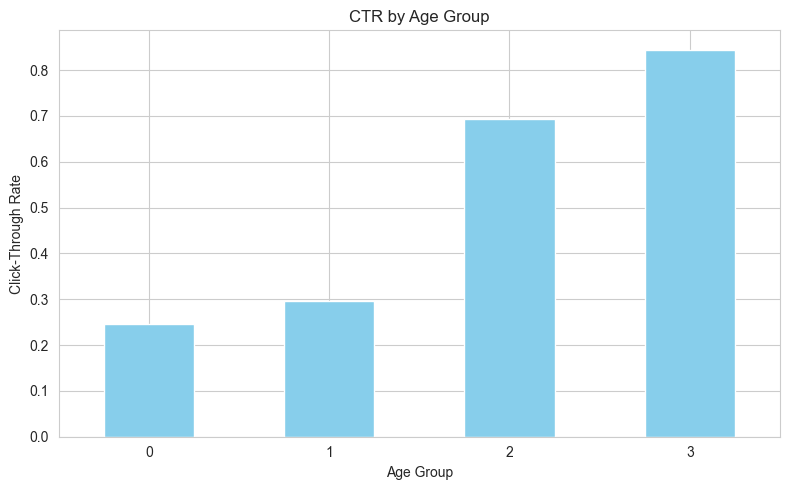

In [17]:

age_clicks = df.groupby('AgeGroup')['Clicked on Ad'].sum()
age_impressions = df.groupby('AgeGroup')['Clicked on Ad'].count()
age_ctr = df.groupby('AgeGroup')['Clicked on Ad'].mean()

print('Total Clicks by Age Group:')
print(age_clicks)
print('\nClick-Through Rate (CTR) by Age Group:')
print(age_ctr)

# Visualize CTR by Age Group
plt.figure(figsize=(8, 5))
age_ctr.plot(kind='bar', color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Click-Through Rate')
plt.title('CTR by Age Group')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()